# Solving the Taxi Problem 

In reinforcement learning, an agent is acting in an environment, and learning by trial-and-error to optimize its performance in order to gain maximal cumulative reward. The model of the environment can be formalized by a Markov Decision Process (MDP), from which the optimal policy can be derived applying dynamic programming algorithms. This is called planning. If the MDP is not known, the agent has to find it out by interacting with the environment. This is called reinforcement learning. Different learning strategies can be applied by the agent to update the value functions and policy while running episodes and collecting samples until the optimal policy is found. 

In the "ReinforcementLearning" module, planning methods as well as learning algorithms are implemented. Both were tested and demonstrated extensively using the Frozen Lake game as environment. In this notebook, some of these algorithms are applied to solve the OpenAI Gym's Taxi-v3 problem. However, the objective of this notebook is not to discuss solutions to the Taxi problem in detail. The only purpose is to show that the "ReinforcementLearning" module is generic and can be extended easily to solve all kinds of reinforcement learning problems. 

## OpenAI Gym's Taxi Game

Taxi is one of the OpenAI Gym environments:
    
https://gym.openai.com/envs/Taxi-v3/
    
The Taxi Problem is adopted from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition" by Tom Dietterich:

<i>"There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends." </i>

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations: 
    
Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
        
The state space is represented by: (taxi_row, taxi_col, passenger_location, destination)

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger
     
There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
Rendering:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations

## Import module ReinforcementLearning 

The "ReinforcementLearning" module has a class "Taxi" that wraps the original OpenAI Gym's "Taxi-v3" object, in the same way the "FrozenLake" class wraps the original "FrozenLake-v0" object. As a matter of fact, class "Taxi" inherits from class "FrozenLake", so it has the same attributes and methods.

When importing the "ReinforcementLearning" module, the "numpy" package is imported as "np" and "matplotlib.pyplot" as "plt". So it is not required to import these packages explicitly. The "ReinforcementLearning" module requires that "matplotlib" is set to the interactive "notebook" plotting mode. Function "sleep" is also imported from package "time", and will be used to slow down the updating of the plots. 

In [1]:
from ReinforcementLearning import *
%matplotlib notebook
from time import sleep

## The Taxi Environment 

Creating a "Taxi" object is done by calling static method "make":

In [2]:
env = Taxi.make()  # time_limit = True is default

By default, a time limited environment is created, because optional argument "time_limit" is "True" if not set. If set to "False", an environment without time limit is defined. The Taxi environment is deterministic and can never be stochastic.

First, the game is played manually to explore the environment, its states, and the possible actions. The start position of the taxi is randomly chosen, as is the pick-up and drop-off location. Therefore, the random seed is set explicitely to ensure method "reset" always renders the same initial state:

In [3]:
env.seed(100)
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The environment is a 5 x 5 grid. There are 4 possible drop-off locations: R, G, Y, B. The one that is colored magenta is the drop-off location, i.e. the passenger's destination. The one colored blue is the pick-up location, i.e. where the passenger waits. The rectangle is the taxi, which is yellow if the passenger is not inside, and blue if he is. The vertical solid lines are walls that cannot be traversed by the taxi.

The "Taxi" class has a "plot" method that shows the same in a more attractive manner:

<IPython.core.display.Javascript object>


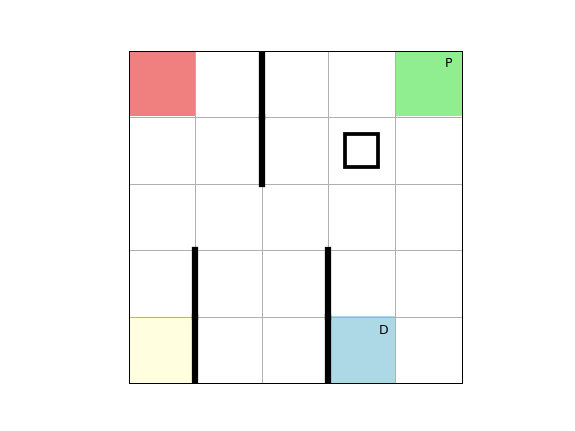

In [4]:
env.plot()

Here, the pick-up location where the passenger waits is indicated by letter "P", and the drop-off location or destination by letter "D". The taxi is a square with black edges. The square is white if the passenger is not inside the taxi, and black otherwise. 

The taxi must drive to the pick-up location, pick-up the passenger, drive to the destination, and drop-off the passenger:

(67, -1, False, {'prob': 1.0})
(87, -1, False, {'prob': 1.0})
(99, -1, False, {'prob': 1.0})
(199, -1, False, {'prob': 1.0})
(299, -1, False, {'prob': 1.0})
(399, -1, False, {'prob': 1.0})
(499, -1, False, {'prob': 1.0})
(479, -1, False, {'prob': 1.0})
(475, 20, True, {'prob': 1.0})


<IPython.core.display.Javascript object>


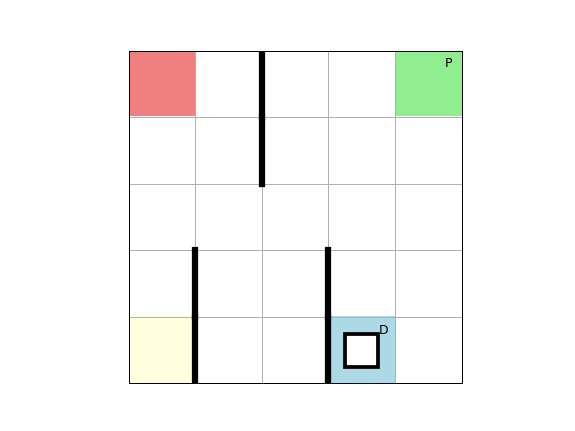

In [5]:
actions = [1, 2, 4, 0, 0, 0, 0, 3, 5]
for a in actions:
    print(env.step(a))
env.plot()

Method "step" was called, which returns the tuple (state, reward, done, info). Each action is penalized with a reward of -1, except when the passenger is dropped-off, then a reward of 20 is given. The state is an index that can be converted into a tuple (taxi_row, taxi_column, passenger, destination) using method "decode": 

In [6]:
print(env.decode(475))

(4, 3, 3, 3)


In final state "475", the taxi is indeed in the fifth row (index 4), the fourth column (index 3), and the passenger is in location "blue" (index 3), which is the destination. Method "encode" converts this tuple to its state index:

In [7]:
print(env.encode(4, 3, 3, 3))

475


A function "update_plot" is defined now, so the whole trajectory of the taxi can be shown instead of the final state only:  

In [8]:
def update_plot(percept):
    global update
    actions = ["move south",
               "move north",
               "move east",
               "move west",
               "pick-up",
               "drop-off"]
    env.plot(update=update, title=actions[percept.action])
    update = True
    sleep(1)

Replaying the game using an agent and plotting all states:

<IPython.core.display.Javascript object>


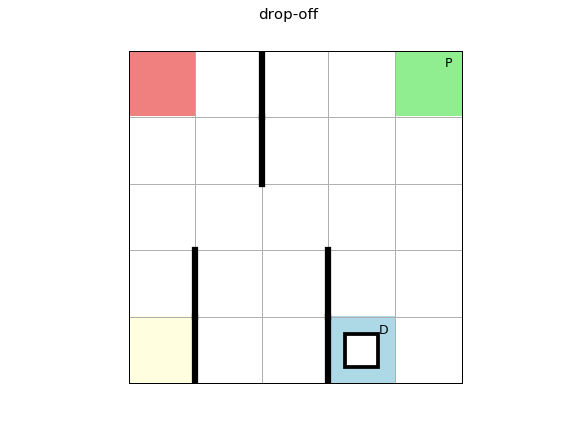

In [9]:
env.seed(100)
env.reset()
env.plot(title="Start")
update = True
sleep(1)

agent = Agent(env)

actions = [1, 2, 4, 0, 0, 0, 0, 3, 5]
for a in actions:
    percept = agent.step(a, update_function=update_plot)

Recall that the agent's "step" method returns a "Percept" object.

## Planning 

The MDP of the Taxi environment is known and stored in attribute "P" of the original "Taxi-v3" object. Using class "GymMDP", one of its dynamic programming methods can be applied to solve this MDP and get the optimal policy:

In [10]:
mdp = GymMDP(env, gamma=0.99)
policy_opt, v_opt, q_opt = mdp.value_iteration(outer=5000)

Discount factor gamma is set to 0.99 instead of 1.0 to ease the convergence of the applied value iteration algorithm.

An agent is created who walks an episode following the episode to see if it is optimal indeed:

<IPython.core.display.Javascript object>


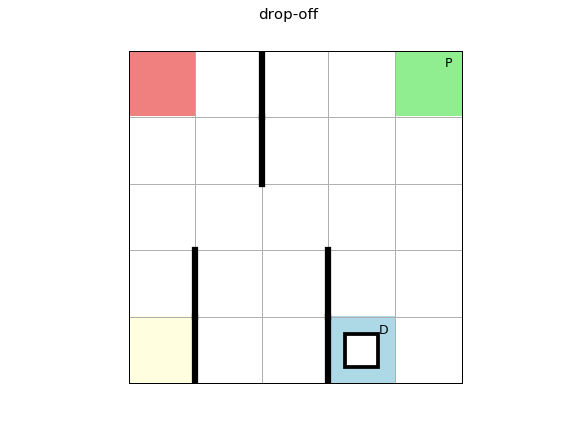

In [11]:
env.seed(100)
policy_opt.seed(10)
agent = Agent(env)
update = False
episode = agent.walk(policy=policy_opt, update_function=update_plot)

The agent drives the taxi following a shortest path to the different locations as it should. Recall that the agent's walk method returns an Episode object that holds the percepts as a numpy array:

In [12]:
print(episode.percepts)

[[167.   2.  -1. 187.]
 [187.   1.  -1.  87.]
 [ 87.   4.  -1.  99.]
 [ 99.   3.  -1.  79.]
 [ 79.   0.  -1. 179.]
 [179.   0.  -1. 279.]
 [279.   0.  -1. 379.]
 [379.   0.  -1. 479.]
 [479.   5.  20. 475.]]


Finally, the agent is running a large number of episodes to check the average return or average total reward of the episodes when the optimal policy is followed:

In [13]:
env.seed(1000)
policy_opt.seed(10)

episodes = agent.run(num_of_episodes=1000, policy=policy_opt)

print(env.num_of_wins(episodes))
print(env.average_return(episodes))

1000
8.106


Static method "num_of_wins" is used to count the number of wins, i.e. the number of times the passenger was dropped-off at the correct destination. In this case the number of wins is 100% as the environment is deterministic. Therefore it is more useful to check the average return using static method "average_return" which indicates how well the agent performs in following a shortest path.

## Learning 

Planning means that the MDP is known and is used to find the optimal policy. In most reinforcement learning problems, the MDP is not given. In this section the agent will use the Monte Carlo learning strategy to find the optimal policy without prior knowledge of the MDP. 

The initial policy will be a uniform random policy. The learning rate is set to 1.0 as the environment is stochastic. The discount factor is set to 0.99 as before. The decay rate is set to 0.0075 and 1000 episodes will be run. The other hyperparameters are automatically set to their default values. The mean Q-value will be monitored, which means it will be saved after each episode.

In [14]:
policy = UniformRandomPolicy(env)

strategy = MonteCarlo(num_of_episodes=1000,
                      policy=policy,
                      learning_rate=1.0,
                      gamma=0.99,
                      decay_rate=0.0075)
strategy.set_monitor(Qsa=np.mean)

agent = Agent(env, strategy)

env.seed(9)
policy.seed(50)
agent.learn()

Plotting the mean Q-value versus the episode number:

<IPython.core.display.Javascript object>


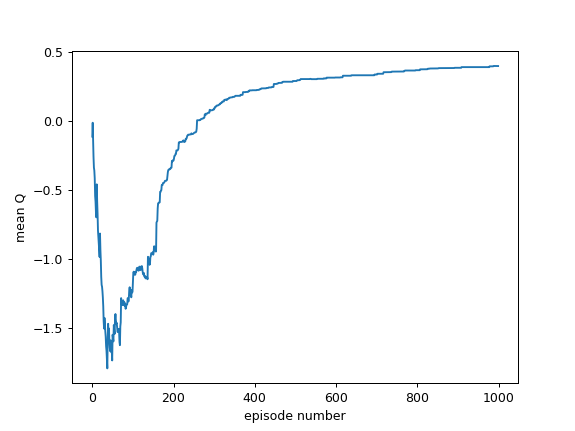

In [15]:
fig = plt.figure()
ax = plt.axes()
ax.plot(strategy.monitor["Qsa"])
ax.set_xlabel("episode number")
ax.set_ylabel("mean Q")
fig.show()
fig.canvas.draw()

Checking the solution by letting the agent drive one episode following the optimized policy:

<IPython.core.display.Javascript object>


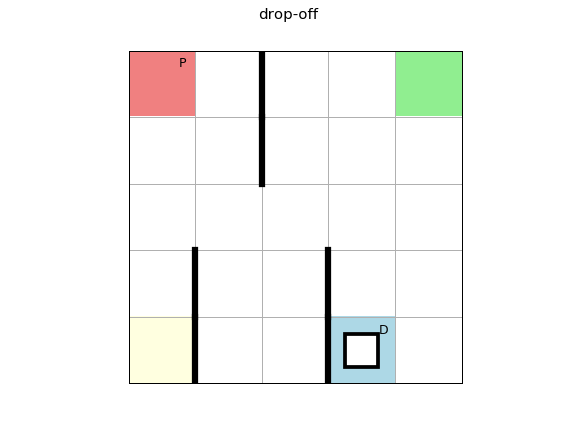

In [16]:
env.seed(1)
strategy.policy.seed(3)
update = False
episode = agent.walk(policy=strategy.policy, update_function=update_plot)

Finally, the solution is checked by letting the agent run a large number of episodes and calculate the average return or average total reward of the episodes when the optimized policy is followed:

In [17]:
env.seed(1000)
policy_opt.seed(10)
episodes = agent.run(num_of_episodes=1000, policy=strategy.policy)
print(env.num_of_wins(episodes))
print(env.average_return(episodes))

1000
4.996


Although the policy optimized by the Monte Carlo method gives a lower average return than the optimal policy, it still lets the agent perform very efficiently.